Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Yiren_Wu"
COLLABORATORS = ""

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.3.1
Version 2, minor 3


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
 


In [3]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [4]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [5]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


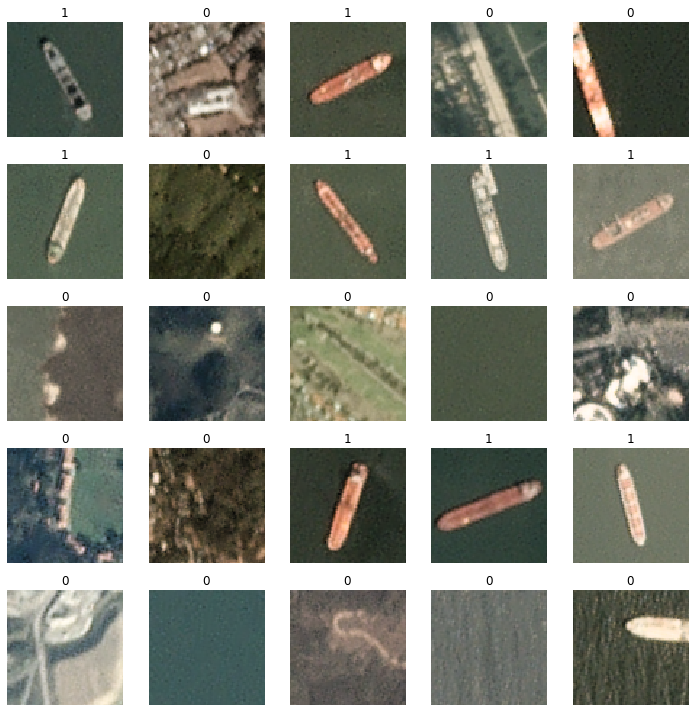

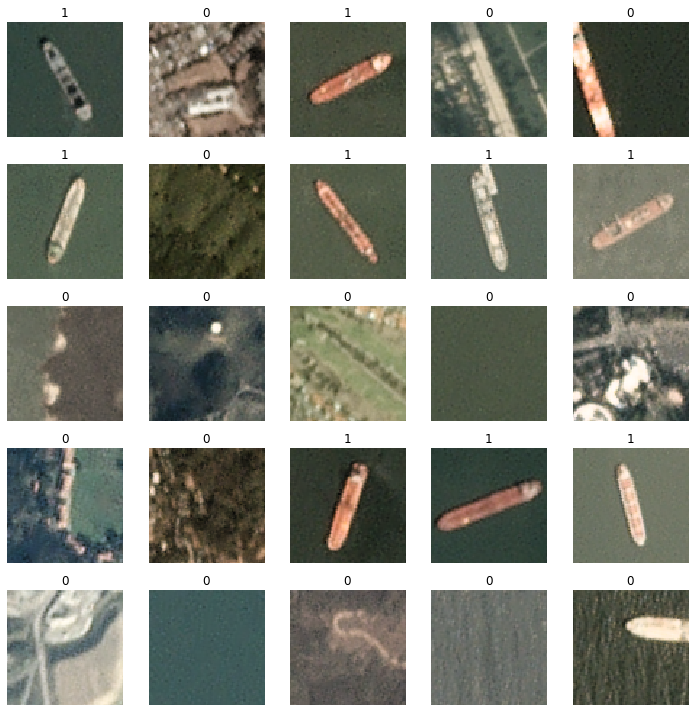

In [6]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


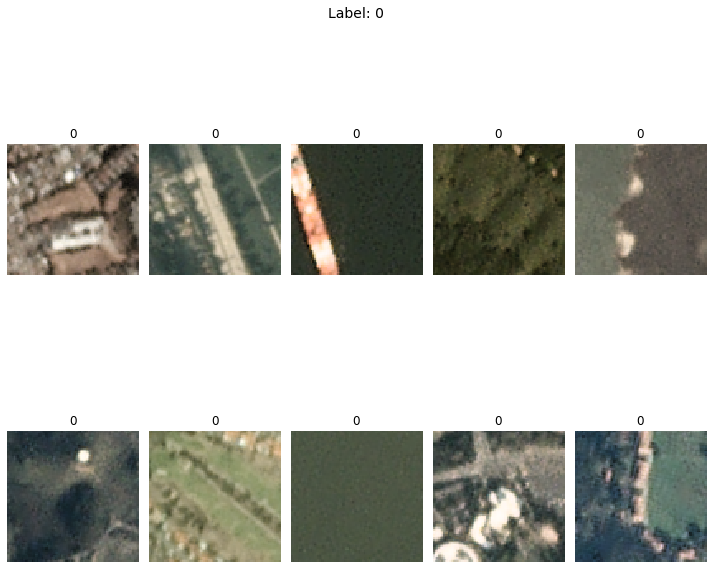

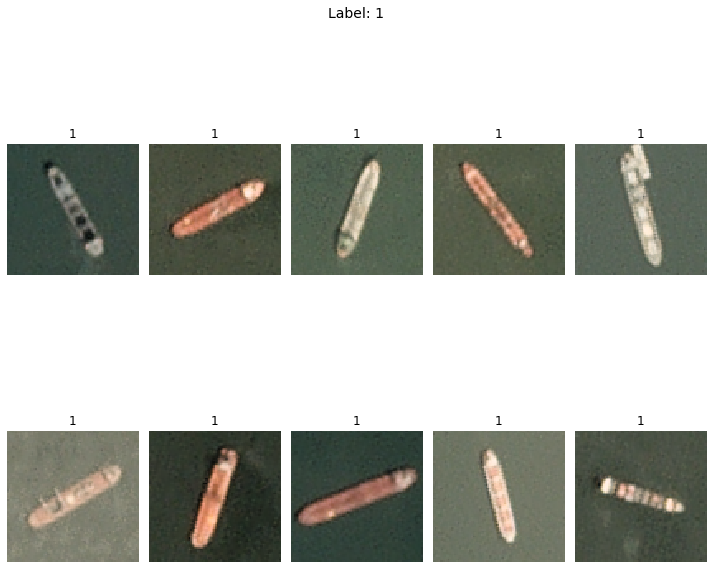

In [7]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our gray-scale examples (`data_bw`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



In [8]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

# YOUR CODE HERE
X = data/255
y = labels

In [9]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [10]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use full padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 



In [11]:
# Set model0 equal to a Keras Sequential model
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model0 = None

num_conv_features1 = 32

# YOUR CODE HERE
model0 = Sequential([ Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,697
Trainable params: 205,697
Non-trainable params: 0
_________________________________________________________________


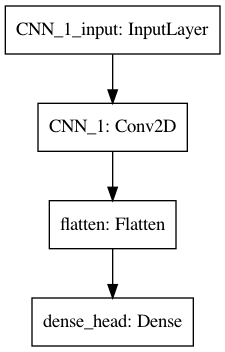

In [12]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/10
90/90 [==============================] - 4s 39ms/step - loss: 0.4625 - accuracy: 0.8017 - val_loss: 0.3378 - val_accuracy: 0.8458
Epoch 2/10
90/90 [==============================] - 3s 37ms/step - loss: 0.3438 - accuracy: 0.8576 - val_loss: 0.2932 - val_accuracy: 0.8736
Epoch 3/10
90/90 [==============================] - 3s 36ms/step - loss: 0.3074 - accuracy: 0.8785 - val_loss: 0.2454 - val_accuracy: 0.8972
Epoch 4/10
90/90 [==============================] - 3s 37ms/step - loss: 0.2670 - accuracy: 0.8965 - val_loss: 0.2162 - val_accuracy: 0.9153
Epoch 5/10
90/90 [==============================] - 3s 35ms/step - loss: 0.2382 - accuracy: 0.9007 - val_loss: 0.2661 - val_accuracy: 0.8986
Epoch 6/10
90/90 [==============================] - 3s 36ms/step - loss: 0.2199 - accuracy: 0.9076 - val_loss: 0.1824 - val_accuracy: 0.9250
Epoch 7/10
90/90 [==============================] - 3s 37ms/step - loss: 0.2167 - accuracy: 0.9090 - val_loss: 0.1751 - val_accuracy: 0.9264
Epoch 8/10
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba9f147590>,
       dtype=object))

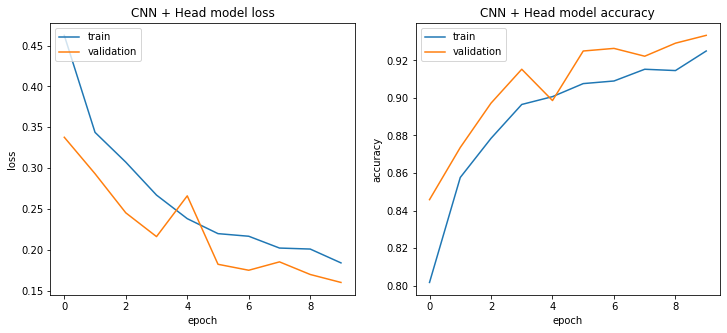

In [13]:
model_name0 = "CNN + Head"
max_epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= max_epochs)

# YOUR CODE HERE
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
model0.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history0 = model0.fit(X_train_, y_train_, epochs = 10, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history0, model_name0)

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [14]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None


# YOUR CODE HERE
num_parameters0 = 0
for i in range(len(model0.get_weights())):
    num_parameters0 += len(model0.get_weights()[i].reshape(-1,))

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  205697


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [15]:
score0 = []

# YOUR CODE HERE
score0 = model0.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))



13/13 [==============================] - 0s 7ms/step - loss: 0.1910 - accuracy: 0.9275
CNN + Head: Test loss: 0.19 / Test accuracy: 0.93


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [16]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Model saved in directory ./models/CNN + Head; create an archive of this directory and submit with your assignment.
Directory ./models/CNN + Head already exists, files will be over-written.


In [17]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [18]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_conv_features1 = 32
num_conv_features2 = 64

# YOUR CODE HERE
model1 = Sequential([ Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                      Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_2"),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_3"),
                      Conv2D(num_conv_features2, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_4"),
                     MaxPooling2D(pool_size=(2, 2)),
                     Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])


model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)            

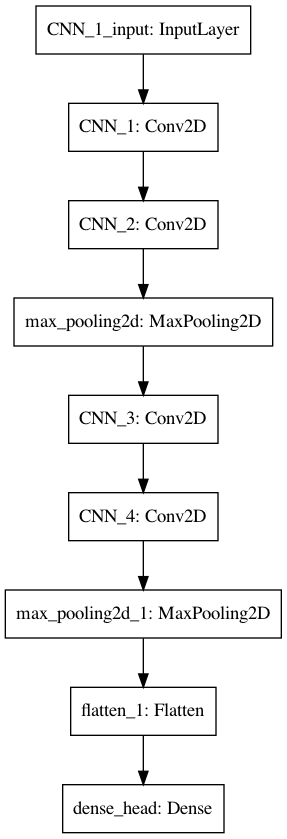

In [19]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



Epoch 1/15
90/90 [==============================] - 21s 231ms/step - loss: 0.5312 - accuracy: 0.7514 - val_loss: 0.4449 - val_accuracy: 0.7889
Epoch 2/15
90/90 [==============================] - 21s 229ms/step - loss: 0.3882 - accuracy: 0.8441 - val_loss: 0.3716 - val_accuracy: 0.8319
Epoch 3/15
90/90 [==============================] - 20s 218ms/step - loss: 0.3377 - accuracy: 0.8587 - val_loss: 0.3982 - val_accuracy: 0.8375
Epoch 4/15
90/90 [==============================] - 20s 219ms/step - loss: 0.2914 - accuracy: 0.8750 - val_loss: 0.2812 - val_accuracy: 0.8764
Epoch 5/15
90/90 [==============================] - 19s 217ms/step - loss: 0.2662 - accuracy: 0.8913 - val_loss: 0.2691 - val_accuracy: 0.8931
Epoch 6/15
90/90 [==============================] - 19s 216ms/step - loss: 0.2332 - accuracy: 0.8976 - val_loss: 0.1952 - val_accuracy: 0.9097
Epoch 7/15
90/90 [==============================] - 19s 216ms/step - loss: 0.2184 - accuracy: 0.9083 - val_loss: 0.1742 - val_accuracy: 0.9236

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba9ca6b350>,
       dtype=object))

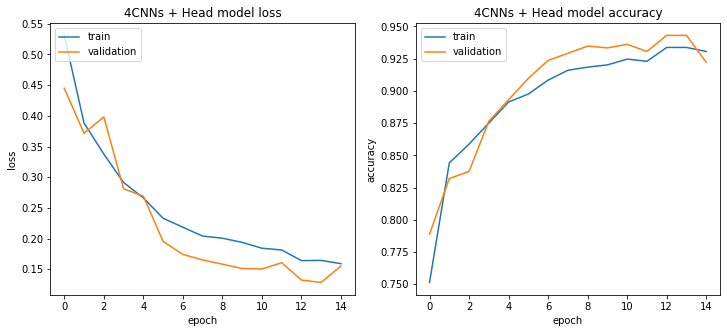

In [20]:
# Train the model using the API
model_name1 = "4CNNs + Head"

# YOUR CODE HERE
model1.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history1 = model1.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid))
helper.plotTrain(history1, model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [21]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE

num_parameters1 = 0
for i in range(len(model1.get_weights())):
    num_parameters1 += len(model1.get_weights()[i].reshape(-1,))


print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 91169


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [22]:
score1 = []

# YOUR CODE HERE
score1 = model1.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

13/13 [==============================] - 0s 31ms/step - loss: 0.1583 - accuracy: 0.9350
4CNNs + Head: Test loss: 0.16 / Test accuracy: 0.94


Is your test accuracy higher than before ?

Test accuracy is better than before

# Save your trained model1 and history1

In [23]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Model saved in directory ./models/4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory ./models/4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


# Test the influence of kernal size on the model result

Kerna size defined as an integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 

## 5*5 kernal size 

When I change the kernal size from (3,3) to (5,5), the number of total parameter increase. It is because Increasing kernel size means effectively increasing the total number of parameters. However, there is no direct relation between the kernel size and the accuracy because larger kernel may result in loosing details in some smaller features.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        2432      
_________________________________________________________________
flatten_2 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 207,233
Trainable params: 207,233
Non-trainable params: 0
_________________________________________________________________


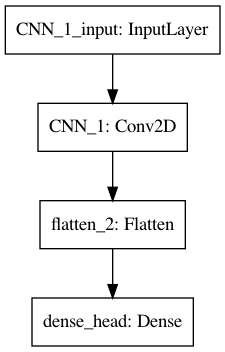

In [24]:
model3 = Sequential([ Conv2D(num_conv_features1, kernel_size=(5, 5),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model3.summary()
plot_model(model3)

## Train the model

Epoch 1/15
90/90 [==============================] - 4s 46ms/step - loss: 0.4801 - accuracy: 0.7920 - val_loss: 0.3367 - val_accuracy: 0.8444
Epoch 2/15
90/90 [==============================] - 4s 44ms/step - loss: 0.3196 - accuracy: 0.8708 - val_loss: 0.2712 - val_accuracy: 0.8847
Epoch 3/15
90/90 [==============================] - 4s 45ms/step - loss: 0.2688 - accuracy: 0.8892 - val_loss: 0.2703 - val_accuracy: 0.8806
Epoch 4/15
90/90 [==============================] - 4s 46ms/step - loss: 0.2508 - accuracy: 0.9066 - val_loss: 0.1924 - val_accuracy: 0.9194
Epoch 5/15
90/90 [==============================] - 4s 46ms/step - loss: 0.2181 - accuracy: 0.9101 - val_loss: 0.1721 - val_accuracy: 0.9264
Epoch 6/15
90/90 [==============================] - 4s 45ms/step - loss: 0.2018 - accuracy: 0.9191 - val_loss: 0.1580 - val_accuracy: 0.9319
Epoch 7/15
90/90 [==============================] - 4s 49ms/step - loss: 0.1979 - accuracy: 0.9191 - val_loss: 0.1811 - val_accuracy: 0.9236
Epoch 8/15
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba5b5aae50>,
       dtype=object))

Parameters number in model3:  207233


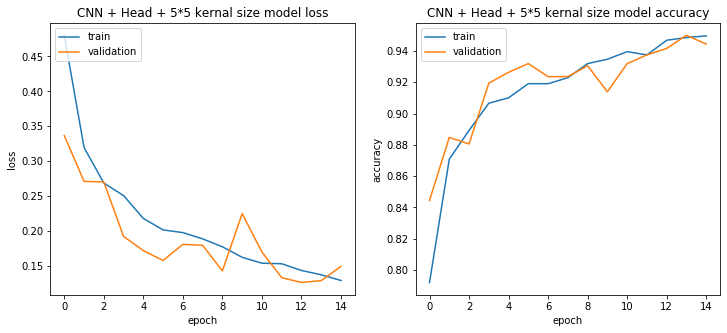

In [25]:
model_name3 = "CNN + Head + 5*5 kernal size"

model3.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history3 = model3.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history3, model_name3)

num_parameters3 = 0
for i in range(len(model3.get_weights())):
    num_parameters3 += len(model3.get_weights()[i].reshape(-1,))

print("Parameters number in model3: ", num_parameters3)

## Evaluate the model

When I change the kernal size from (3,3) to (5,5), test loss decrease a little, test accuracy decrease a little.
The reason is the large kernal size will make memory usage smaller, which means it gives you loss a lot of details. 
SO my next experiment is to decrease kernal size to see the change.


In [26]:
score3 = []

# YOUR CODE HERE
score3 = model3.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name3, l=score3[0], a=score3[1]))



13/13 [==============================] - 0s 8ms/step - loss: 0.1930 - accuracy: 0.9225
CNN + Head + 5*5 kernal size: Test loss: 0.19 / Test accuracy: 0.92


## 2*2 Kernal size

When I decrease the kernal size from (3,3) to (2,2), the number of total parameters decrease. In summary, larger lernal size will lead to larger parameters number.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        416       
_________________________________________________________________
flatten_3 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,217
Trainable params: 205,217
Non-trainable params: 0
_________________________________________________________________


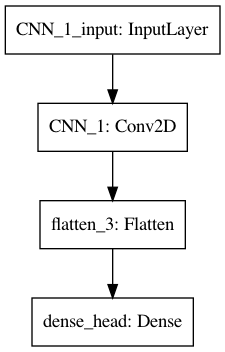

In [27]:
model4 = Sequential([ Conv2D(num_conv_features1, kernel_size=(2, 2),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model4.summary()
plot_model(model4)

## Train the model

Epoch 1/15
90/90 [==============================] - 3s 32ms/step - loss: 0.4642 - accuracy: 0.7979 - val_loss: 0.3508 - val_accuracy: 0.8556
Epoch 2/15
90/90 [==============================] - 3s 31ms/step - loss: 0.3605 - accuracy: 0.8486 - val_loss: 0.3256 - val_accuracy: 0.8569
Epoch 3/15
90/90 [==============================] - 2s 27ms/step - loss: 0.3021 - accuracy: 0.8687 - val_loss: 0.3047 - val_accuracy: 0.8569
Epoch 4/15
90/90 [==============================] - 3s 31ms/step - loss: 0.2669 - accuracy: 0.8892 - val_loss: 0.2335 - val_accuracy: 0.9028
Epoch 5/15
90/90 [==============================] - 3s 30ms/step - loss: 0.2403 - accuracy: 0.9024 - val_loss: 0.2129 - val_accuracy: 0.9125
Epoch 6/15
90/90 [==============================] - 3s 32ms/step - loss: 0.2354 - accuracy: 0.9059 - val_loss: 0.1960 - val_accuracy: 0.9194
Epoch 7/15
90/90 [==============================] - 3s 29ms/step - loss: 0.2163 - accuracy: 0.9125 - val_loss: 0.1890 - val_accuracy: 0.9278
Epoch 8/15
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba5b59cdd0>,
       dtype=object))

Parameters number in model4:  205217


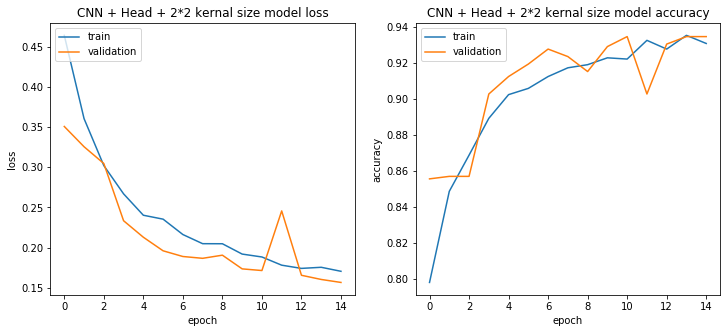

In [28]:
model_name4 = "CNN + Head + 2*2 kernal size"

model4.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history4 = model4.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history4, model_name4)

num_parameters4 = 0
for i in range(len(model4.get_weights())):
    num_parameters4 += len(model4.get_weights()[i].reshape(-1,))

print("Parameters number in model4: ", num_parameters4)

## Evaluate the model

When I decrease the kernal size to (2,2), the loss increase and the test accuracy even decrease. I think it is because of overfitting.
Smaller kernel will gives you a lot of details and memory usage is bigger. Therefore (3,3) is the best choice.

In [29]:
score4 = []

# YOUR CODE HERE
score4 = model4.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name4, l=score4[0], a=score4[1]))



13/13 [==============================] - 0s 7ms/step - loss: 0.1759 - accuracy: 0.9300
CNN + Head + 2*2 kernal size: Test loss: 0.18 / Test accuracy: 0.93


# Test the influence of the number of features of Convolutional layers

## num_conv_features = 16

The number of total parameters decrease when I decrease num_conv_features from 32 to 16.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 16)        448       
_________________________________________________________________
flatten_4 (Flatten)          (None, 102400)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 102401    
Total params: 102,849
Trainable params: 102,849
Non-trainable params: 0
_________________________________________________________________


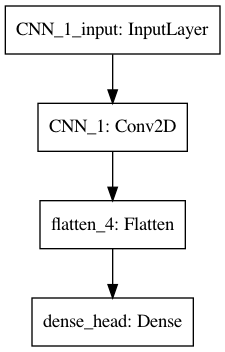

In [30]:
model5 = Sequential([ Conv2D(16, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model5.summary()
plot_model(model5)

## Train the model

Epoch 1/15
90/90 [==============================] - 2s 21ms/step - loss: 0.5517 - accuracy: 0.7951 - val_loss: 0.3513 - val_accuracy: 0.8389
Epoch 2/15
90/90 [==============================] - 2s 20ms/step - loss: 0.3557 - accuracy: 0.8469 - val_loss: 0.3119 - val_accuracy: 0.8625
Epoch 3/15
90/90 [==============================] - 2s 20ms/step - loss: 0.3072 - accuracy: 0.8691 - val_loss: 0.2670 - val_accuracy: 0.8917
Epoch 4/15
90/90 [==============================] - 2s 20ms/step - loss: 0.2831 - accuracy: 0.8854 - val_loss: 0.2809 - val_accuracy: 0.8792
Epoch 5/15
90/90 [==============================] - 2s 20ms/step - loss: 0.2604 - accuracy: 0.8917 - val_loss: 0.2185 - val_accuracy: 0.9056
Epoch 6/15
90/90 [==============================] - 2s 20ms/step - loss: 0.2459 - accuracy: 0.8997 - val_loss: 0.2109 - val_accuracy: 0.9056
Epoch 7/15
90/90 [==============================] - 2s 20ms/step - loss: 0.2293 - accuracy: 0.9069 - val_loss: 0.1898 - val_accuracy: 0.9222
Epoch 8/15
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbae0baf890>,
       dtype=object))

Parameters number in model5:  102849


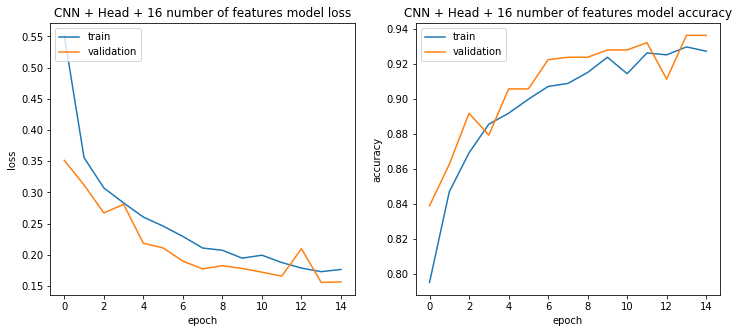

In [31]:
model_name5 = "CNN + Head + 16 number of features"

model5.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history5 = model5.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history5, model_name5)

num_parameters5 = 0
for i in range(len(model5.get_weights())):
    num_parameters5 += len(model5.get_weights()[i].reshape(-1,))

print("Parameters number in model5: ", num_parameters5)

## Evaluate the model

There is no big difference when I change the num_conv_features from 32 to 18. The loss slightly increase and accracy slightly decrease. Therefore, I will test the more extreme case in my next experiement.

In [32]:
score5 = []

# YOUR CODE HERE
score5 = model5.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name5, l=score5[0], a=score5[1]))



13/13 [==============================] - 0s 5ms/step - loss: 0.1740 - accuracy: 0.9250
CNN + Head + 16 number of features: Test loss: 0.17 / Test accuracy: 0.93


## num_conv_features = 8

The number of parameters shrink even more when I futher decrease the num_conv_features from 16 to 8. 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 8)         224       
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 51201     
Total params: 51,425
Trainable params: 51,425
Non-trainable params: 0
_________________________________________________________________


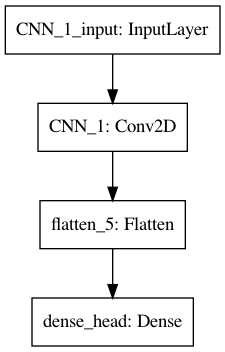

In [33]:
model6 = Sequential([ Conv2D(8, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model6.summary()
plot_model(model6)

## Train the model

Epoch 1/15
90/90 [==============================] - 1s 14ms/step - loss: 0.4972 - accuracy: 0.8021 - val_loss: 0.3867 - val_accuracy: 0.8333
Epoch 2/15
90/90 [==============================] - 1s 13ms/step - loss: 0.3649 - accuracy: 0.8483 - val_loss: 0.3392 - val_accuracy: 0.8500
Epoch 3/15
90/90 [==============================] - 1s 13ms/step - loss: 0.3271 - accuracy: 0.8733 - val_loss: 0.2895 - val_accuracy: 0.8806
Epoch 4/15
90/90 [==============================] - 1s 13ms/step - loss: 0.2966 - accuracy: 0.8799 - val_loss: 0.2636 - val_accuracy: 0.8861
Epoch 5/15
90/90 [==============================] - 1s 13ms/step - loss: 0.2708 - accuracy: 0.8899 - val_loss: 0.2652 - val_accuracy: 0.8861
Epoch 6/15
90/90 [==============================] - 1s 13ms/step - loss: 0.2405 - accuracy: 0.9080 - val_loss: 0.2137 - val_accuracy: 0.9042
Epoch 7/15
90/90 [==============================] - 1s 13ms/step - loss: 0.2222 - accuracy: 0.9104 - val_loss: 0.1919 - val_accuracy: 0.9194
Epoch 8/15
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba5b97ac10>,
       dtype=object))

Parameters number in model5:  51425


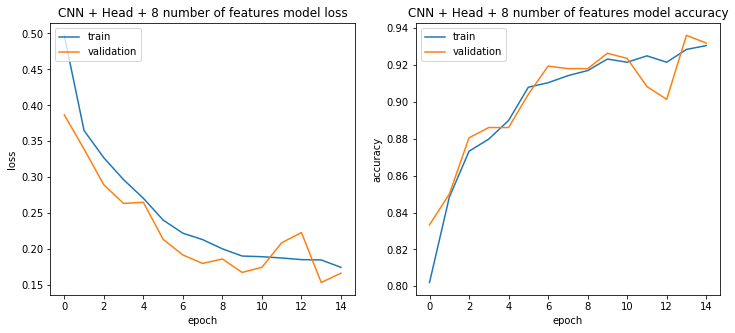

In [34]:
model_name6 = "CNN + Head + 8 number of features"

model6.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history6 = model6.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history6, model_name6)

num_parameters6 = 0
for i in range(len(model6.get_weights())):
    num_parameters6 += len(model6.get_weights()[i].reshape(-1,))

print("Parameters number in model5: ", num_parameters6)

## Evaluate the model

 The test loss increase and accuracy decrease when I switch to 8 filters. Based on our test result, the model achieve best result on the test set when num_conv_features = 32. 

In [35]:
score6 = []

# YOUR CODE HERE
score6 = model6.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name6, l=score6[0], a=score6[1]))



13/13 [==============================] - 0s 4ms/step - loss: 0.1877 - accuracy: 0.9300
CNN + Head + 8 number of features: Test loss: 0.19 / Test accuracy: 0.93


# Experiment with AveragePooling2D VS MaxPooling2D

## Create the model

The number of total parameters doesn't change when I switch the maxpooling2D into AveragePooling2D.

In [36]:
from tensorflow.keras.layers import AveragePooling2D

model7 = Sequential([ Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                      Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_2"),
                     AveragePooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_3"),
                      Conv2D(num_conv_features2, kernel_size=(3, 3),padding="same", activation='relu',input_shape= (80,80,3)
                            , name = "CNN_4"),
                     AveragePooling2D(pool_size=(2, 2)),
                     Dropout(0.25),
                     Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])


model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 20, 20, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 64)       

Epoch 1/15
90/90 [==============================] - 19s 217ms/step - loss: 0.5221 - accuracy: 0.7576 - val_loss: 0.4204 - val_accuracy: 0.8111
Epoch 2/15
90/90 [==============================] - 19s 216ms/step - loss: 0.3937 - accuracy: 0.8319 - val_loss: 0.3372 - val_accuracy: 0.8569
Epoch 3/15
90/90 [==============================] - 20s 217ms/step - loss: 0.3514 - accuracy: 0.8531 - val_loss: 0.3054 - val_accuracy: 0.8708
Epoch 4/15
90/90 [==============================] - 19s 215ms/step - loss: 0.3147 - accuracy: 0.8694 - val_loss: 0.2681 - val_accuracy: 0.8833
Epoch 5/15
90/90 [==============================] - 19s 216ms/step - loss: 0.2794 - accuracy: 0.8882 - val_loss: 0.3007 - val_accuracy: 0.8722
Epoch 6/15
90/90 [==============================] - 19s 215ms/step - loss: 0.2573 - accuracy: 0.8931 - val_loss: 0.2221 - val_accuracy: 0.8958
Epoch 7/15
90/90 [==============================] - 19s 216ms/step - loss: 0.2443 - accuracy: 0.8969 - val_loss: 0.1985 - val_accuracy: 0.9097

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba5c290390>,
       dtype=object))

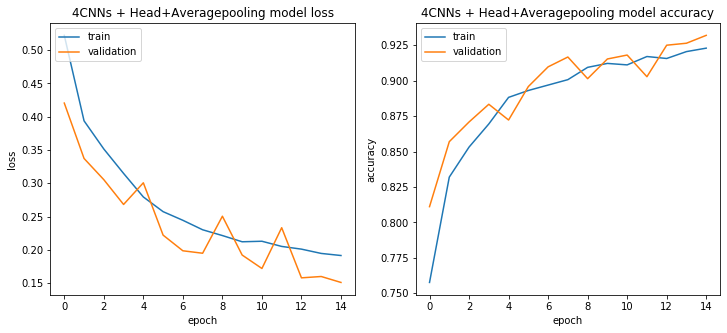

In [37]:
# Train the model using the API
model_name7 = "4CNNs + Head+Averagepooling"

# YOUR CODE HERE
model7.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history7 = model7.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid),callbacks = [callback])
helper.plotTrain(history7, model_name7)

In [38]:
num_parameters7 = 0
for i in range(len(model7.get_weights())):
    num_parameters7 += len(model7.get_weights()[i].reshape(-1,))

print("Parameters number in model5: ", num_parameters7)

Parameters number in model5:  91169


## Evaluate the model

When I use Averagepooling instead of MaxPooling, the test accuracy and the test loss doesn't change a lot.

Max pooling extracts the most important features like edges whereas, average pooling extracts features so smoothly. And max-pooling layers are worse at preserving localization.

In [39]:
score7 = []

# YOUR CODE HERE
score7 = model7.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name7, l=score7[0], a=score7[1]))

13/13 [==============================] - 0s 28ms/step - loss: 0.2055 - accuracy: 0.9150
4CNNs + Head+Averagepooling: Test loss: 0.21 / Test accuracy: 0.92


# Change the activation function

## Model with  Selu activation function

change of the activation function will have no influence on the total number of parameters

In [40]:
model8 = Sequential([ Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='selu',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten_7 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,697
Trainable params: 205,697
Non-trainable params: 0
_________________________________________________________________


## Train the model

Epoch 1/15
90/90 [==============================] - 4s 39ms/step - loss: 1.1867 - accuracy: 0.7819 - val_loss: 0.3209 - val_accuracy: 0.8750
Epoch 2/15
90/90 [==============================] - 3s 36ms/step - loss: 0.2588 - accuracy: 0.8875 - val_loss: 0.2218 - val_accuracy: 0.9125
Epoch 3/15
90/90 [==============================] - 3s 37ms/step - loss: 0.2231 - accuracy: 0.9108 - val_loss: 0.2051 - val_accuracy: 0.9111
Epoch 4/15
90/90 [==============================] - 3s 37ms/step - loss: 0.2069 - accuracy: 0.9160 - val_loss: 0.1757 - val_accuracy: 0.9292
Epoch 5/15
90/90 [==============================] - 3s 37ms/step - loss: 0.1909 - accuracy: 0.9247 - val_loss: 0.1662 - val_accuracy: 0.9361
Epoch 6/15
90/90 [==============================] - 3s 36ms/step - loss: 0.1766 - accuracy: 0.9309 - val_loss: 0.1600 - val_accuracy: 0.9361
Epoch 7/15
90/90 [==============================] - 3s 37ms/step - loss: 0.1697 - accuracy: 0.9292 - val_loss: 0.1584 - val_accuracy: 0.9389
Epoch 8/15
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba1b671250>,
       dtype=object))

Parameters number in model8:  205697


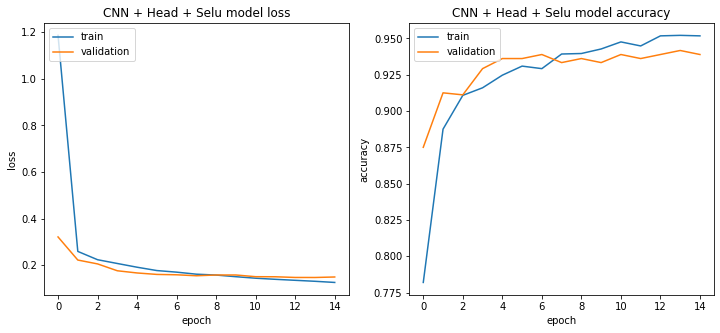

In [41]:
model_name8 = "CNN + Head + Selu"

model8.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history8 = model8.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history8, model_name8)

num_parameters8 = 0
for i in range(len(model8.get_weights())):
    num_parameters8 += len(model8.get_weights()[i].reshape(-1,))

print("Parameters number in model8: ", num_parameters8)

## Evaluate the model

The SELU activation is self-normalizing the neural network. Test loss increase and accuracy decrease when I switch to selu activaion function

In [42]:
score8 = []

# YOUR CODE HERE
score8 = model8.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name8, l=score8[0], a=score8[1]))

13/13 [==============================] - 0s 9ms/step - loss: 0.1579 - accuracy: 0.9325
CNN + Head + Selu: Test loss: 0.16 / Test accuracy: 0.93


## Model with tanh activation function

Activation function type will have no influence on the total number of parameters. The total number of parameters is still 205697.

In [43]:
model9 = Sequential([ Conv2D(num_conv_features1, kernel_size=(3, 3),padding="same", activation='tanh',input_shape= (80,80,3)
                            , name = "CNN_1"),
                    Flatten(),Dense(1, activation='sigmoid', name = "dense_head" )])

model9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten_8 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,697
Trainable params: 205,697
Non-trainable params: 0
_________________________________________________________________


## Train the model

Epoch 1/15
90/90 [==============================] - 4s 39ms/step - loss: 0.5519 - accuracy: 0.8052 - val_loss: 0.3121 - val_accuracy: 0.8681
Epoch 2/15
90/90 [==============================] - 3s 36ms/step - loss: 0.3196 - accuracy: 0.8736 - val_loss: 0.2883 - val_accuracy: 0.8875
Epoch 3/15
90/90 [==============================] - 3s 37ms/step - loss: 0.2762 - accuracy: 0.8854 - val_loss: 0.2284 - val_accuracy: 0.9125
Epoch 4/15
90/90 [==============================] - 3s 36ms/step - loss: 0.2532 - accuracy: 0.8951 - val_loss: 0.2330 - val_accuracy: 0.9056
Epoch 5/15
90/90 [==============================] - 3s 35ms/step - loss: 0.2241 - accuracy: 0.9094 - val_loss: 0.1909 - val_accuracy: 0.9236
Epoch 6/15
90/90 [==============================] - 3s 36ms/step - loss: 0.2210 - accuracy: 0.9080 - val_loss: 0.1861 - val_accuracy: 0.9250
Epoch 7/15
90/90 [==============================] - 3s 36ms/step - loss: 0.2033 - accuracy: 0.9167 - val_loss: 0.1795 - val_accuracy: 0.9306
Epoch 8/15
90

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba1ba82450>,
       dtype=object))

Parameters number in model9:  205697


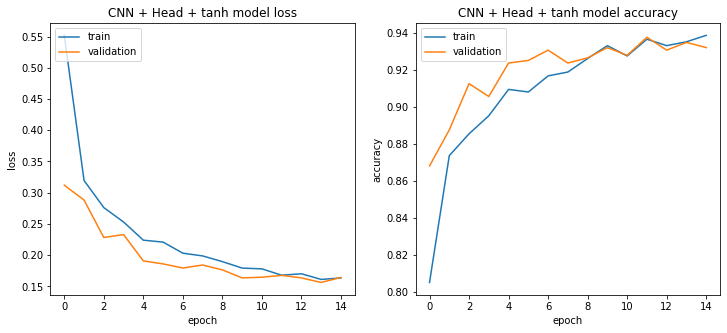

In [44]:
model_name9 = "CNN + Head + tanh"

model9.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history9 = model9.fit(X_train_, y_train_, epochs = 15, validation_data = (X_valid, y_valid), callbacks = [callback])
helper.plotTrain(history9, model_name9)

num_parameters9 = 0
for i in range(len(model9.get_weights())):
    num_parameters9 += len(model9.get_weights()[i].reshape(-1,))

print("Parameters number in model9: ", num_parameters9)

## Evaluate the result

The result shows that relu activation function work best. Compared with relu, the test loss increase to 0.23, and test accuracy decrease to 0.91 when using tanh.

In [45]:
score9 = []

# YOUR CODE HERE
score9 = model9.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name9, l=score9[0], a=score9[1]))

13/13 [==============================] - 0s 9ms/step - loss: 0.1810 - accuracy: 0.9275
CNN + Head + tanh: Test loss: 0.18 / Test accuracy: 0.93
